In [1]:
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/beans_dataset.tar.gz

--2024-07-13 13:15:11--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/beans_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 52.217.108.172, 3.5.24.250, 52.217.192.177, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|52.217.108.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179790562 (171M) [application/x-gzip]
Saving to: ‘beans_dataset.tar.gz’

beans_dataset.tar.g 100%[===================>] 171.46M  44.0MB/s    in 4.3s    

2024-07-13 13:15:16 (39.8 MB/s) - ‘beans_dataset.tar.gz’ saved [179790562/179790562]



In [2]:
import tarfile

def extract_tar_gz(file_path, output_path):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=output_path)

# Use it like this:
extract_tar_gz('/content/beans_dataset.tar.gz', '/content/')

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, initializers
import matplotlib.pyplot as plt

train_set = tf.keras.utils.image_dataset_from_directory(
    directory='beans/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(227, 227))

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory='beans/validation/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(227, 227))

test_set = tf.keras.utils.image_dataset_from_directory(
    directory='beans/test/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(227, 227))

train_imgs = train_set.map(lambda imgs, labels: imgs)
normalization_layer = layers.Normalization(axis=-1)
normalization_layer.adapt(train_imgs)

train_set_normalized = train_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))
validation_set_normalized = validation_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))
test_set_normalized = test_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.


In [4]:
model = tf.keras.Sequential()

model.add(layers.Conv2D(64, (5,5), activation='relu', input_shape=(227, 227, 3), strides=2, padding='valid'))
model.add(layers.MaxPooling2D( (3,3), strides=2 ))
model.add(layers.Conv2D(64, (5,5), activation='relu', strides=2, padding='same'))
model.add(layers.MaxPooling2D( (3,3), strides=1 ))
model.add(layers.Conv2D(128, (5,5), activation='relu', strides=2, padding='same'))
model.add(layers.MaxPooling2D( (3,3), strides=1 ))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 55, 55, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 26, 26, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       204928    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 11, 11, 128)       0

In [5]:
opt= tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [6]:
history= model.fit(train_set_normalized, epochs=25, validation_data=validation_set_normalized)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


33/33 [==============================] - 14s 185ms/step - loss: 1.6616 - accuracy: 0.4768 - val_loss: 0.9000 - val_accuracy: 0.5639
Epoch 2/25
33/33 [==============================] - 5s 121ms/step - loss: 0.8140 - accuracy: 0.6325 - val_loss: 0.7162 - val_accuracy: 0.6842
Epoch 3/25
33/33 [==============================] - 5s 121ms/step - loss: 0.6860 - accuracy: 0.7050 - val_loss: 0.8202 - val_accuracy: 0.6015
Epoch 4/25
33/33 [==============================] - 4s 113ms/step - loss: 0.6425 - accuracy: 0.7205 - val_loss: 0.5913 - val_accuracy: 0.7368
Epoch 5/25
33/33 [==============================] - 6s 163ms/step - loss: 0.5623 - accuracy: 0.7534 - val_loss: 0.6349 - val_accuracy: 0.7293
Epoch 6/25
33/33 [==============================] - 5s 123ms/step - loss: 0.5474 - accuracy: 0.7611 - val_loss: 0.5504 - val_accuracy: 0.8045
Epoch 7/25
33/33 [==============================] - 6s 140ms/step - loss: 0.4963 - accuracy: 0.7853 - val_loss: 0.6397 - val_accuracy: 0.7368
Epoch 8/25
33/33

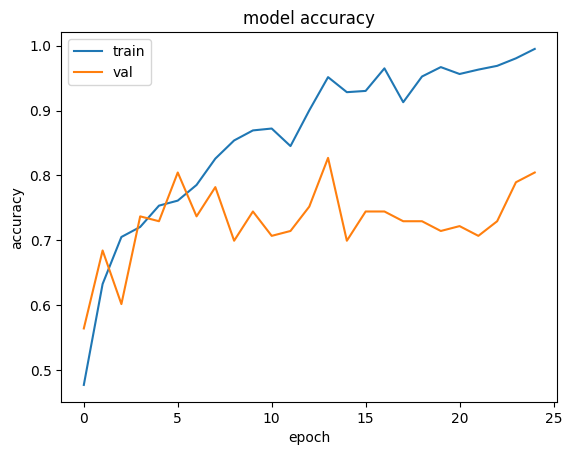

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


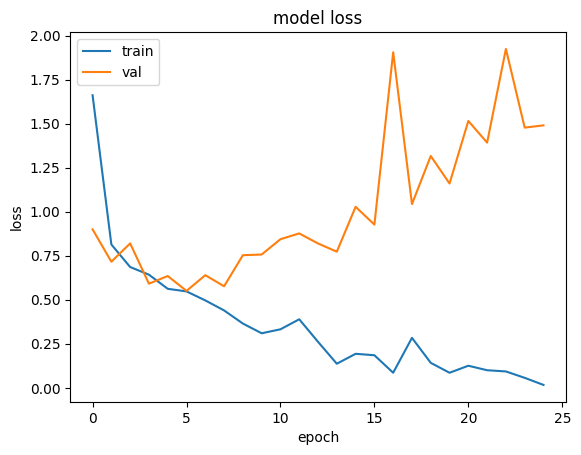

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [9]:
test_loss, test_acc = model.evaluate(test_set_normalized)
print(test_acc)

4/4 [==============================] - 0s 38ms/step - loss: 1.5051 - accuracy: 0.8047
0.8046875


In [10]:
model = tf.keras.Sequential()

model.add(layers.Conv2D(64, (5,5), activation='relu', input_shape=(227, 227, 3), strides=2, padding='valid'))
model.add(layers.MaxPooling2D( (3,3), strides=2 ))
model.add(layers.Conv2D(64, (5,5), activation='relu', strides=2, padding='same'))
model.add(layers.MaxPooling2D( (3,3), strides=1 ))
model.add(layers.Conv2D(128, (5,5), activation='relu', strides=2, padding='same'))
model.add(layers.MaxPooling2D( (3,3), strides=1 ))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

callback= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

opt= tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

history= model.fit(train_set_normalized, epochs=25, validation_data=validation_set_normalized, callbacks=[callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      4864      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 55, 55, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        102464    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 26, 26, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 128)       204928    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 11, 11, 128)      

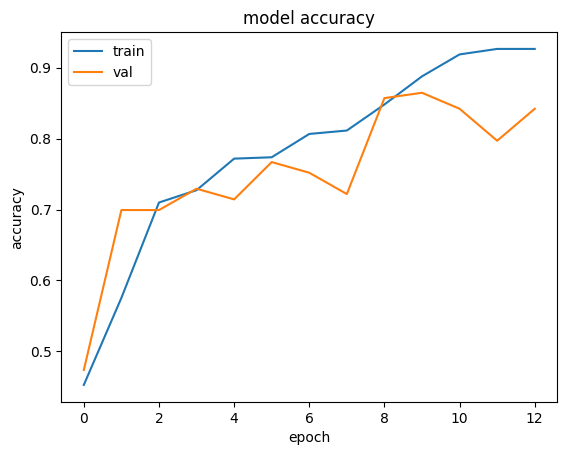

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


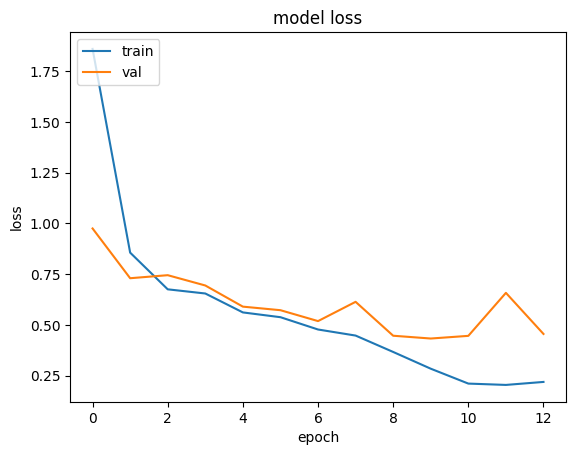

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [13]:
model = tf.keras.Sequential()

model.add(layers.Conv2D(64, (5,5), activation='relu', input_shape=(227, 227, 3), strides=2, padding='valid'))
model.add(layers.MaxPooling2D( (3,3), strides=2 ))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Conv2D(64, (5,5), activation='relu', strides=2, padding='same'))
model.add(layers.MaxPooling2D( (3,3), strides=1 ))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Conv2D(128, (5,5), activation='relu', strides=2, padding='same'))
model.add(layers.MaxPooling2D( (3,3), strides=1 ))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Flatten())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(3, activation='softmax'))


model.summary()

# callback= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

opt= tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

history= model.fit(train_set_normalized, epochs=25, validation_data=validation_set_normalized) #, callbacks=[callback]


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      4864      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 55, 55, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 55, 55, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        102464    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 26, 26, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 26, 26, 64)       

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


33/33 [==============================] - 8s 123ms/step - loss: 1.3741 - accuracy: 0.3636 - val_loss: 0.9635 - val_accuracy: 0.5113
Epoch 2/25
33/33 [==============================] - 5s 120ms/step - loss: 1.0188 - accuracy: 0.4807 - val_loss: 0.9861 - val_accuracy: 0.4436
Epoch 3/25
33/33 [==============================] - 4s 111ms/step - loss: 0.9632 - accuracy: 0.5696 - val_loss: 0.8719 - val_accuracy: 0.6241
Epoch 4/25
33/33 [==============================] - 6s 158ms/step - loss: 0.8827 - accuracy: 0.6093 - val_loss: 0.8089 - val_accuracy: 0.6541
Epoch 5/25
33/33 [==============================] - 4s 117ms/step - loss: 0.8247 - accuracy: 0.6480 - val_loss: 0.7988 - val_accuracy: 0.6316
Epoch 6/25
33/33 [==============================] - 5s 143ms/step - loss: 0.7419 - accuracy: 0.6838 - val_loss: 0.7507 - val_accuracy: 0.6692
Epoch 7/25
33/33 [==============================] - 5s 124ms/step - loss: 0.7492 - accuracy: 0.6731 - val_loss: 0.6450 - val_accuracy: 0.7293
Epoch 8/25
33/33 

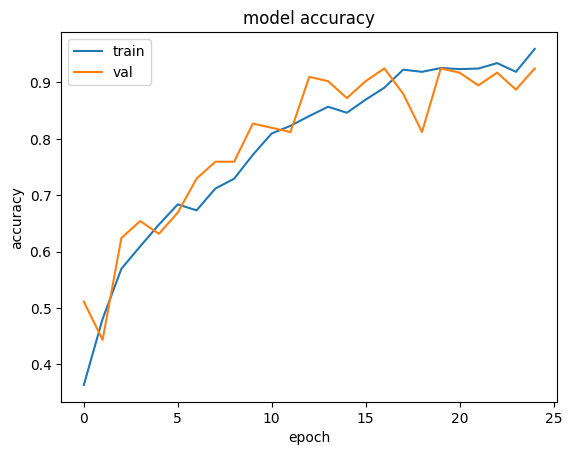

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

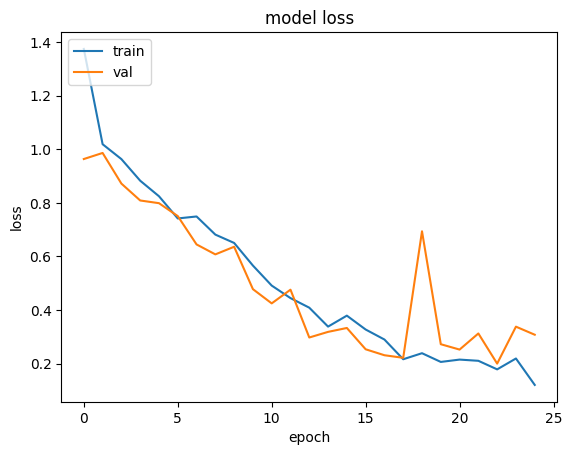

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [19]:
model = tf.keras.Sequential()

model.add(layers.Conv2D(64, (5,5), activation='relu', input_shape=(227, 227, 3), strides=2, padding='valid'))
model.add(layers.MaxPooling2D( (3,3), strides=2 ))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (5,5), activation='relu', strides=2, padding='same'))
model.add(layers.MaxPooling2D( (3,3), strides=1 ))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, (5,5), activation='relu', strides=2, padding='same'))
model.add(layers.MaxPooling2D( (3,3), strides=1 ))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(3, activation='softmax'))


model.summary()

opt= tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

history= model.fit(train_set_normalized, epochs=25, validation_data=validation_set_normalized)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 112, 112, 64)      4864      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 55, 55, 64)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_5 (Bat  (None, 55, 55, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 64)        102464    
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 26, 26, 64)        0         
 ng2D)                                                           
                                                      

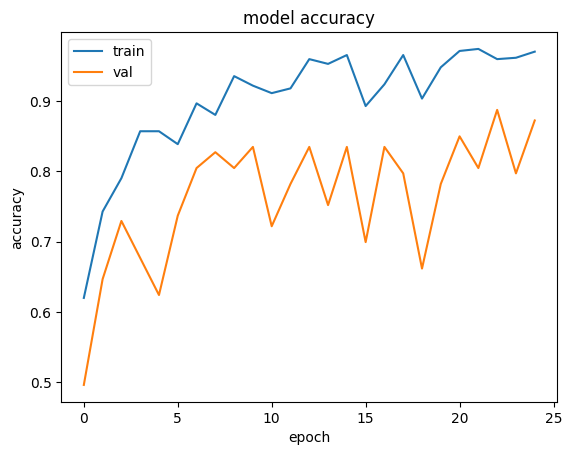

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

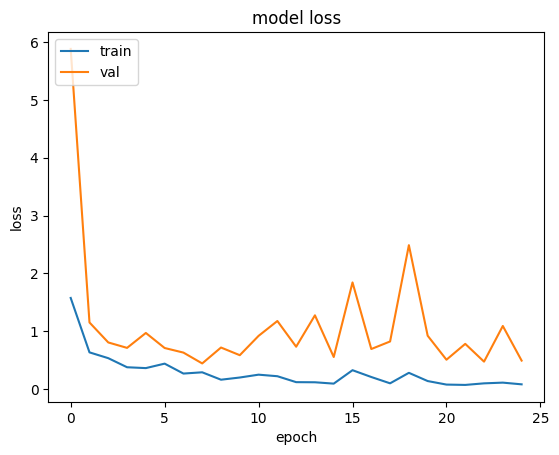

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [22]:
model = tf.keras.Sequential()

model.add(layers.Conv2D(64, (5,5), activation='relu', input_shape=(227, 227, 3), strides=2, padding='valid'))
model.add(layers.MaxPooling2D( (3,3), strides=2 ))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Conv2D(64, (5,5), activation='relu', strides=2, padding='same'))
model.add(layers.MaxPooling2D( (3,3), strides=1 ))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Conv2D(128, (5,5), activation='relu', strides=2, padding='same'))
model.add(layers.MaxPooling2D( (3,3), strides=1 ))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Flatten())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(3, activation='softmax'))


model.summary()

opt= tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

history= model.fit(train_set_normalized, epochs=25, validation_data=validation_set_normalized)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 112, 112, 64)      4864      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 55, 55, 64)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_10 (Ba  (None, 55, 55, 64)        256       
 tchNormalization)                                               
                                                                 
 dropout_5 (Dropout)         (None, 55, 55, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 64)        102464    
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 26, 26, 64)       

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


33/33 [==============================] - 9s 157ms/step - loss: 1.5249 - accuracy: 0.6025 - val_loss: 1.6027 - val_accuracy: 0.6316
Epoch 2/25
33/33 [==============================] - 5s 122ms/step - loss: 1.0621 - accuracy: 0.6818 - val_loss: 0.8737 - val_accuracy: 0.6541
Epoch 3/25
33/33 [==============================] - 5s 118ms/step - loss: 0.8231 - accuracy: 0.7408 - val_loss: 0.7332 - val_accuracy: 0.7143
Epoch 4/25
33/33 [==============================] - 6s 139ms/step - loss: 0.6782 - accuracy: 0.7727 - val_loss: 0.8470 - val_accuracy: 0.7519
Epoch 5/25
33/33 [==============================] - 4s 111ms/step - loss: 0.6506 - accuracy: 0.7843 - val_loss: 0.6996 - val_accuracy: 0.7368
Epoch 6/25
33/33 [==============================] - 6s 154ms/step - loss: 0.5726 - accuracy: 0.8075 - val_loss: 0.5787 - val_accuracy: 0.7895
Epoch 7/25
33/33 [==============================] - 4s 114ms/step - loss: 0.4720 - accuracy: 0.8433 - val_loss: 1.0054 - val_accuracy: 0.7594
Epoch 8/25
33/33 

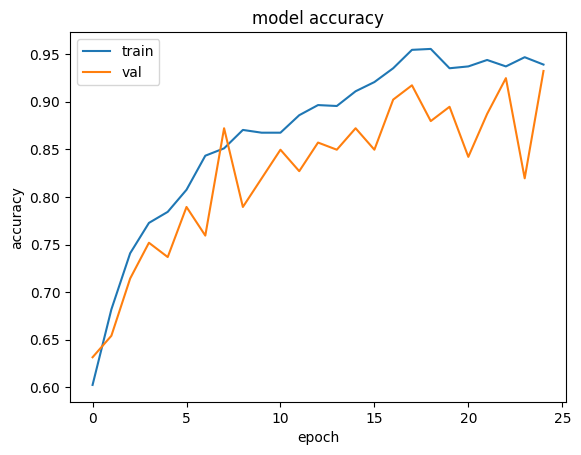

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

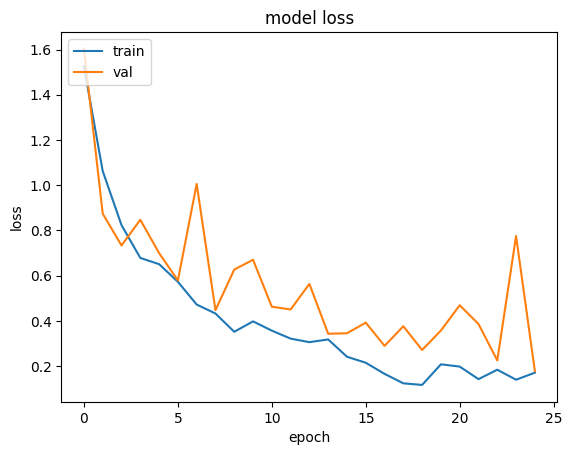

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [25]:
test_loss, test_acc= model.evaluate(test_set_normalized)
print(test_acc)

4/4 [==============================] - 1s 56ms/step - loss: 0.3153 - accuracy: 0.9141
0.9140625


In [34]:
model = tf.keras.Sequential()

model.add(layers.RandomFlip(mode='horizontal_and_vertical'))
model.add(layers.RandomRotation(factor=0.5))
model.add(layers.Conv2D(64, (5,5), activation='relu', input_shape=(227, 227, 3), strides=2, padding='valid'))
model.add(layers.MaxPooling2D( (3,3), strides=2 ))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Conv2D(64, (5,5), activation='relu', strides=2, padding='same'))
model.add(layers.MaxPooling2D( (3,3), strides=1 ))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Conv2D(128, (5,5), activation='relu', strides=2, padding='same'))
model.add(layers.MaxPooling2D( (3,3), strides=1 ))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Flatten())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(3, activation='softmax'))


# model.summary()

opt= tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

history= model.fit(train_set_normalized, epochs=25, validation_data=validation_set_normalized)


Epoch 1/25
33/33 [==============================] - 9s 131ms/step - loss: 1.6327 - accuracy: 0.5658 - val_loss: 1.2060 - val_accuracy: 0.6241
Epoch 2/25
33/33 [==============================] - 4s 115ms/step - loss: 1.2018 - accuracy: 0.6267 - val_loss: 1.3995 - val_accuracy: 0.6165
Epoch 3/25
33/33 [==============================] - 5s 148ms/step - loss: 1.0677 - accuracy: 0.6567 - val_loss: 0.6137 - val_accuracy: 0.7519
Epoch 4/25
33/33 [==============================] - 5s 120ms/step - loss: 1.0216 - accuracy: 0.6702 - val_loss: 0.7451 - val_accuracy: 0.7293
Epoch 5/25
33/33 [==============================] - 6s 140ms/step - loss: 0.9928 - accuracy: 0.6644 - val_loss: 0.4960 - val_accuracy: 0.8045
Epoch 6/25
33/33 [==============================] - 5s 139ms/step - loss: 0.7799 - accuracy: 0.7340 - val_loss: 0.7039 - val_accuracy: 0.7368
Epoch 7/25
33/33 [==============================] - 5s 120ms/step - loss: 0.7736 - accuracy: 0.7166 - val_loss: 0.6036 - val_accuracy: 0.7669
Epoch 

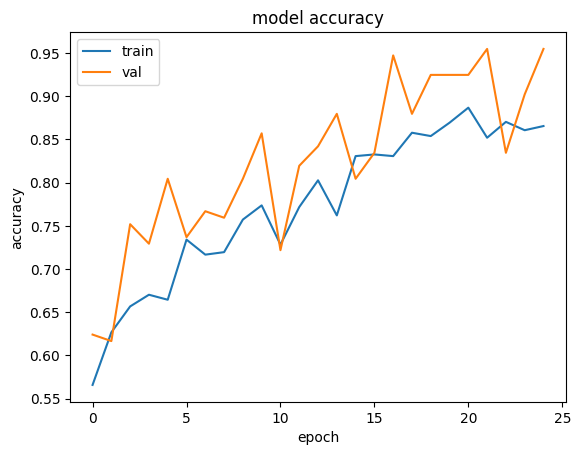

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

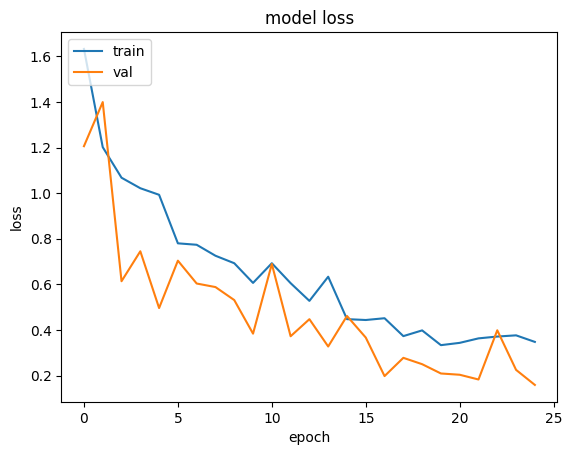

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [38]:
test_loss, test_acc= model.evaluate(test_set_normalized)
print(test_acc)

4/4 [==============================] - 0s 37ms/step - loss: 0.2969 - accuracy: 0.8750
0.875
